# Topological regularization of cell cycle embedding

In this notebook, we show how a topological loss can be combined with a linear embedding procedure, as to regularize the embedding and better reflect the topological---in this case circular---prior. 

We start by setting the working directory and importing the necessary libraries.

In [1]:
# Set working directory
import os
os.chdir("..")

# Tracking computation times
import time

# Handling arrays and data.frames
import pandas as pd 
import numpy as np

# Loading R objects into python
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# Functions for deep learning (Pytorch)
import torch
from torch import nn

# Pytorch compatible topology layer
from topologylayer.nn import AlphaLayer
from topembed import DiagramFeature

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Ordinary PCA embedding
from sklearn.decomposition import PCA

%matplotlib inline

## Load data and view ordinary PCA embedding

We now loading the data and visualize it by means of its ordinary PCA embedding.

Data shape: (264, 6812)


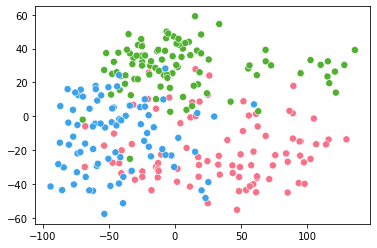

In [2]:
# Load the data
file_name = os.path.join("Data", "CellCycle.rds")
cell_info = ro.r["readRDS"](file_name)
cell_info = dict(zip(cell_info.names, list(cell_info)))

pandas2ri.activate()
data = ro.conversion.rpy2py(cell_info["expression"])
t = list(ro.conversion.rpy2py(cell_info["cell_info"])
         .rename(columns={"milestone_id": "group_id"}).loc[:,"group_id"])
pandas2ri.deactivate()

print("Data shape: " + str(data.shape))

# Conduct ordinary PCA embedding
Y_pca = PCA(n_components=2, random_state=42).fit_transform(data)

# View the data through its PCA embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_pca[:,0], y=Y_pca[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

## Apply topological regularization to the embedding

We now show how we can bias a linear embedding using a loss function that captures our topological prior.

The model we will use for this learns a linear projection $W$, which is optimized for the following three losses:
- the reconstruction loss between our data and its $X$ low-rank approximation $XWW^T$;
- a loss function encouraging orthonormality of $W$;
- a loss function that captures our topological prior.

In [9]:
def TPCA(X, dim, top_criterion, lambda_W=1e4, num_epochs=2000, learning_rate=1e-3, eps=1e-07, random_state=None):
    
    # Center the data
    X = X - X.mean(axis=1, keepdims=True)
    
    # Initialize the linear embedding with PCA
    W = PCA(n_components=dim, random_state=random_state).fit(X).components_.transpose()
    W = torch.tensor(W).type(torch.float)
    W = torch.autograd.Variable(W, requires_grad=True)
    
    # Store losses for exploration
    losses = np.zeros([num_epochs, 3])
    
    # Initialize the optimization
    if not random_state is None:
        torch.manual_seed(random_state)
    
    X = torch.tensor(X).type(torch.float)  
    optimizer = torch.optim.Adam([W], lr=learning_rate, eps=eps)
    MSE = nn.MSELoss()
    
    # Conduct the optimization
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        P = torch.matmul(X, W) # projection of X onto subspace W
        L = torch.matmul(P, torch.transpose(W, 0, 1)) # low-rank reconstruction of X
        emb_loss = MSE(L, X) # MSE between X and low-rank reconstruction
        IW = torch.matmul(torch.transpose(W, 0, 1), W) # correlation between projection vectors W
        W_loss = lambda_W * torch.norm((IW - torch.eye(2))) # loss to encourage orthonormality of W
        top_loss = top_criterion(P) # topological loss
        losses[epoch,:] = [emb_loss.item(), W_loss.item(), top_loss.item()]
        loss = emb_loss + W_loss + top_loss
        loss.backward()
        optimizer.step()
        
        if epoch == 0 or (epoch + 1) % (int(num_epochs / 10)) == 0:
            print ("[epoch %d] [embedding loss: %f, orthonormality loss: %f, top loss: %f]" % 
                   (epoch + 1, emb_loss, W_loss, top_loss))
    
    W = W.detach().numpy() # optimized subspace for projection
    Y = np.dot(X.numpy(), W) # data projection onto W
    losses = pd.DataFrame(losses, columns=["emb", "W", "top"]) # dataframe storing our losses
    
    return(Y, W, losses)

As a topological loss, we will use the persistence of the most prominent cycle in our embedding. It is important to multiply this by a factor $\lambda_{\mathrm{top}} <0$, since we want this persistence to be high. To obtain this loss, we require an additional layer that constructs the alpha complex from the embedding, from which subsequently persistent homology is computed.

In [10]:
# Define topological optimization

def g(p): return p[1] - p[0] # function that returns the persistence d - b of a point (b, d)
top_layer = AlphaLayer(maxdim=1) # alpha complex layer
circular_persistence = DiagramFeature(dim=1, j=1, g=g) # compute persistence of most prominent cycle
lambda_top = -1e1 # scalar factor that trades off embedding and topological loss

# Construct topological loss criterion

def top_criterion(output):
    
    dgminfo = top_layer(output)
    loss = lambda_top * circular_persistence(dgminfo)
    
    return loss

We can now conduct the topologically regularized linear embedding as follows.

[epoch 1] [embedding loss: 12.994524, orthonormality loss: 0.003576, top loss: -74.845062]
[epoch 200] [embedding loss: 13.032412, orthonormality loss: 268.962341, top loss: -546.554993]
[epoch 400] [embedding loss: 13.045926, orthonormality loss: 84.443100, top loss: -652.821106]
[epoch 600] [embedding loss: 13.052706, orthonormality loss: 96.613007, top loss: -667.674011]
[epoch 800] [embedding loss: 13.057422, orthonormality loss: 29.406052, top loss: -633.291992]
[epoch 1000] [embedding loss: 13.058144, orthonormality loss: 162.254608, top loss: -670.813538]
[epoch 1200] [embedding loss: 13.059639, orthonormality loss: 41.692867, top loss: -654.111938]
[epoch 1400] [embedding loss: 13.061508, orthonormality loss: 194.033173, top loss: -678.436218]
[epoch 1600] [embedding loss: 13.063404, orthonormality loss: 116.120148, top loss: -680.093750]
[epoch 1800] [embedding loss: 13.062674, orthonormality loss: 190.598679, top loss: -679.713745]
[epoch 2000] [embedding loss: 13.061602, ort

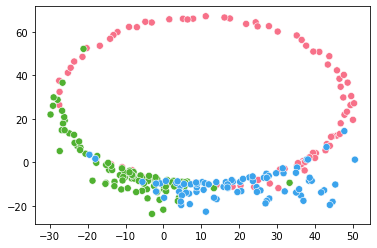

In [11]:
# Conduct topological optimization
num_epochs = 2000
learning_rate = 1e-3

start_time = time.time()
Y_top, W, losses = TPCA(data, 2, top_criterion, num_epochs=num_epochs, learning_rate=learning_rate, 
                        random_state=42)
elapsed_time = time.time() - start_time
print("Time for embedding: " + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

# View topologically regularized embedding
fig, ax = plt.subplots()
sns.scatterplot(x=Y_top[:,0], y=Y_top[:,1], s=50, hue=t, palette="husl")
ax.get_legend().remove()
plt.show()

Finally, we compare the evolution of the embedding and topological losses during optimization.

Reconstruction error increased by: 0.5161992598423601%.
Persistence increased by: 810.3446532407647%.


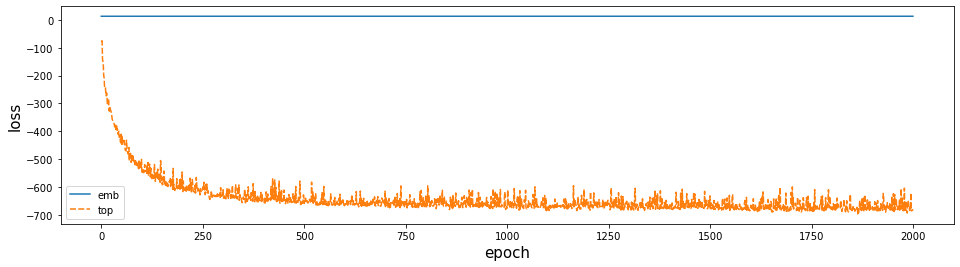

In [12]:
print("Reconstruction error increased by: " + 
      str(100 * (losses["emb"][num_epochs - 1] - losses["emb"][0]) / losses["emb"][0]) + "%.")
print("Persistence increased by: " + 
      str(100 * (losses["top"][num_epochs - 1] - losses["top"][0]) / losses["top"][0]) + "%.")

fig, ax = plt.subplots(figsize=(16, 4))
sns.lineplot(ax=ax, data=losses.loc[:,["emb", "top"]])
ax.set_xlabel("epoch", fontsize=15)
ax.set_ylabel("loss", fontsize=15)
plt.show()

We observe that we can regularize our linear embedding through the topological prior, obtaining a much more prominent cycle, while maintaining a nearly identical reconstruction error.